# Solving simple Blackjack

The book 'Reinforcement Learning: An Introduction' by Richard Sutton and Andrew Barto covers the application of reinforcement learning techniques to Blackjack and other games.

The authors discuss how Blackjack can be modeled as a Markov decision process (MDP), where the player's action (hit or stand) influence the outcome of the game. They explain now reinforcement learning algorithms can be used to learn optimal policies for playing Blackjack, based on maximizing the expected reward over the long term.

The book presents several approaches to solving the Blackjack problem, including Monte Carlo methods and temporal difference learning. It also covers topics such as value funcitons and policy improvement, which are fundamental to reinforcement learning.

In [13]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pygame

from matplotlib.patches import Patch
from collections import defaultdict
from tqdm import tqdm
from IPython.display import clear_output
from __future__ import annotations

In [14]:
env = gym.make('Blackjack-v1', sab=True, render_mode="rgb_array")

#### Step 1: Observing the enviroment
Note: Our observation is a tuple consisting of 3 values:
1. The players current sum
2. Value of the dealers face-up card
3. Boolean whether the player holds a useable ace

In [15]:
#reset the environment to get the first observation
done = False
observation, info = env.reset()

#observation = (16,9,False)
print (observation)

(9, 10, 0)


#### Executing an action
After receiving our first observation, we are only going to use the ``env.step(action)`` function to interact with the environment. This function takes an action as input and executes it in the environment. Because that action changes the state of the environment, it returns four useful variables to us. These are:
- ``next_step``: This is the observation that the agent will receive after taking the action.
- ``reward``: This is the reward that the agent will receive after taking the action.
- ``terminated``: This is a boolean variable that indicates whether or not hte environment has terminated.
- ``truncated``: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e. a time limit is reached.
- ``info``: This is a dictionary that might contain additional information about the environment.

The ``next_state``, ``reward``, ``terminated``, and ``truncated`` variables are self-explanatory, but the ``info`` variable requires some additional explanation. This variable contains a dictionary that might have some extra information about the environment, but in the Blackjack-v1 environment you can ignore it. For example in Atari environments the info dictionary has a ``ale.lives`` key that tells us how many lives the agent has left. If the agent has 0 lives, then the episode is over,

In [16]:
#sample a random action from all valid actions
action = env.action_space.sample() #action 1

#execute the action in out environment and receive info after taking the step
observation, reward, terminated, truncated, info = env.step(action)

#if terminated = True we should stop the current episode and begin a new one using env.reset()
print(observation, reward, terminated, truncated, info)

(20, 10, 1) 0.0 False False {}


#### Epsilon-greedy strategy to solve Blackjack
1. In this strategy, the agent takes an action that is either the best action based on the current policy (with a probability of 1-epsilon) or a random action (with a probability of epsilon). This approach balances the exploitation of the current best policy with exploration of new policies, which can lead to better rewards in the long run.

2. In the context of Blackjack, the epsilon-greedy strategy can be applied to determine wether the player should hit or stand. At each step of the game, the agent (i.e. the player) can choose to take the action that is either recommended by the current policy or a random action. The policy is learned over time by updating the action-value estimates of each state-action pair based on the rewards received during the game.

3. As the game is played repeatedly, the agent learns the optimal policy that maximizes the expected reward. Initially, the agent may explore by taking random actions to discover new strategies. However, as the game progresses, the agent will start to exploit the best-known policy, which should maximize the expected reward over time.


In [17]:
class BlackjackAgent:
    def __init__(
            self,
            learning_rate:float,
            initial_epsilon:float,
            epsilon_decay:float,
            final_epsilon:float,
            discount_factor:float = 0.95
            ) -> None:
        """
        Initialize a RL agent with empty dictionary of state-action value (q_values), a learning rate and an epsilon

        discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda:np.zeros(env.action_space.n))
        
        self.lr =learning_rate
        self.discount_factor = discount_factor
        
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action (self, obs:tuple[int, int,bool]) -> int:
        """
        Returns the best action with probability (1-epsilon) otherwise a random action with probability epsilon to ensure exploration
        """
        
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(
            self,
            obs:tuple[int, int,bool],
            action:int,
            reward:float,
            terminated:bool,
            next_obs:tuple[int, int,bool]
            ) -> None:
        """
        Updates the Q-value of an action 
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

#### Q-value function
It is used to estimate the optimal action to take in each state. It is the one that maximizes the long-term reward and is given by.

To train the agent, we will let the agent play one episode (one complete game is called an episode) at a time and the update it's Q-values after each episode. The agent will have to experience a lot of episodes to explore the environment sufficiently.

In [18]:
#hyperparameters
learning_rate = 0.01
n_episodes = 5000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) #reduce the exploration over time
final_epsilon = 0.1

#agent
agent = BlackjackAgent(
    learning_rate = learning_rate,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon 
)

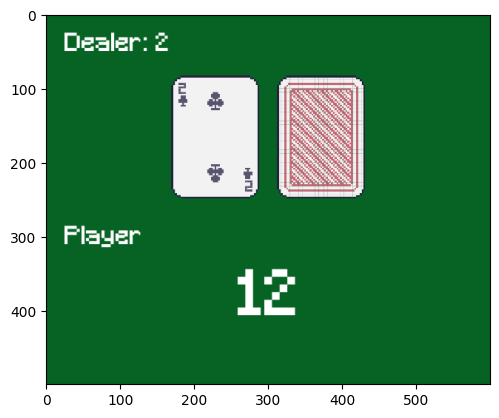

100%|██████████| 5000/5000 [15:06<00:00,  5.52it/s]


In [19]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    clear_output()

    #play one episode:
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        #
        agent.update(obs, action, reward, terminated, next_obs)
        frame =  env.render()
        plt.imshow(frame)
        plt.show()

        #
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

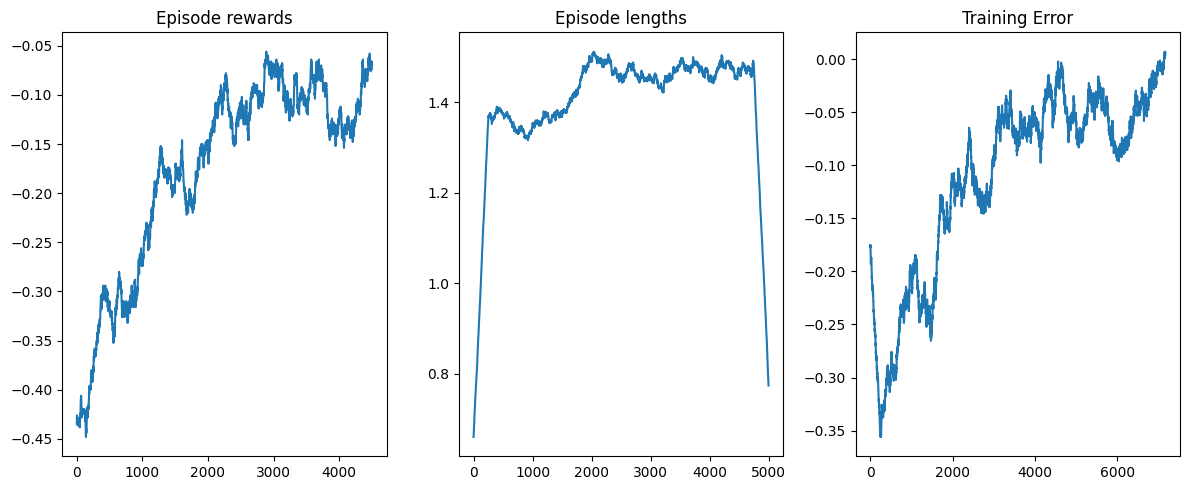

In [20]:
rolling_length = 500
fid, axs = plt.subplots(ncols=3, figsize=(12,5))
axs[0].set_title("Episode rewards")
reward_moving_average= (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode ='valid'
    ) / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = (
        np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode='same'
    ) / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode='same') / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()